In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

In [2]:
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')

### Introdução

Nosso objetivo com este projeto é classificar a partir de dados demográficos e médicos se um paciente possui diabetes ou não.

## Funções globais

In [3]:
results = []

def get_results(algorithm, predicted, results_list):
    results_list.append({
        algorithm: [
            {'0': {
                'precision': predicted['0']['precision'],
                'recall': predicted['0']['recall']
            }},
            {'1': {
                'precision': predicted['1']['precision'],
                'recall': predicted['1']['recall']
            }}
        ]
    })
    return results_list

def plot_results(results_list):
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.2

    ax.set_xlabel('Algoritmos')
    ax.set_ylabel('Valores')
    ax.set_title('Precision e Recall por Algoritmo e Classe')

    indices = list(range(len(results_list)))
    algorithms = [list(result.keys())[0] for result in results_list]

    precision_0 = []
    recall_0 = []
    precision_1 = []
    recall_1 = []

    for result in results_list:
        algorithm = list(result.keys())[0]
        metrics = result[algorithm]
        for metric in metrics:
            if '0' in metric:
                precision_0.append(metric['0']['precision'])
                recall_0.append(metric['0']['recall'])
            if '1' in metric:
                precision_1.append(metric['1']['precision'])
                recall_1.append(metric['1']['recall'])

    positions_0_precision = [i - width for i in indices]
    positions_0_recall = [i for i in indices]
    positions_1_precision = [i + width for i in indices]
    positions_1_recall = [i + 2*width for i in indices]

    ax.bar(positions_0_precision, precision_0, width, label='Class 0 precision', color='blue')
    ax.bar(positions_0_recall, recall_0, width, label='Class 0 recall', color='green')
    ax.bar(positions_1_precision, precision_1, width, label='Class 1 precision', color='blue', alpha=0.5)
    ax.bar(positions_1_recall, recall_1, width, label='Class 1 recall', color='green', alpha=0.5)

    ax.set_xticks([i + width/2 for i in indices])
    ax.set_xticklabels(algorithms)
    ax.legend()

    for i, v in enumerate(positions_0_precision):
        ax.text(v, precision_0[i] + 0.01, f"{precision_0[i]:.2f}", color='blue', ha='center')
    for i, v in enumerate(positions_0_recall):
        ax.text(v, recall_0[i] + 0.01, f"{recall_0[i]:.2f}", color='green', ha='center')
    for i, v in enumerate(positions_1_precision):
        ax.text(v, precision_1[i] + 0.01, f"{precision_1[i]:.2f}", color='blue', ha='center', alpha=0.5)
    for i, v in enumerate(positions_1_recall):
        ax.text(v, recall_1[i] + 0.01, f"{recall_1[i]:.2f}", color='green', ha='center', alpha=0.5)

    plt.tight_layout()
    plt.show()

def plot_hist(x, var_name, n_bins, x_label, y_label):
    plt.hist(x, bins=n_bins, edgecolor='black')
    plt.title(f'Distribuição da Variável {var_name}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def plot_bar(x, var_name, x_label, y_label, ticks, labels):
    x.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f'Contagem de valores da variável {var_name}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(ticks=ticks, labels=labels, rotation=0)
    plt.show()


## Analise exploratória dos dados

Nosso dataset possui nove variáveis, sendo duas variáveis categóricas chamadas de gender e smoking_history. As variáveis hypertension e heart_disease são variáveis binárias, e o restante são variáveis numéricas.

Por fim, a variável que queremos classificar é chamada de diabetes. Casos positivos de diabetes são representados com o valor 1, enquanto os negatvos são representados com valor 0.

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


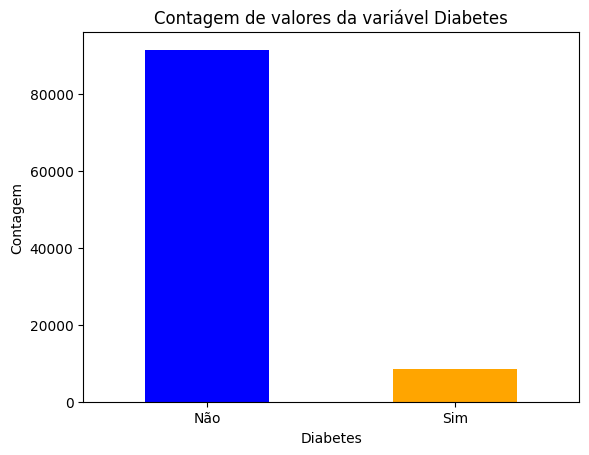

In [ ]:
plot_bar(x=df['diabetes'].value_counts(), var_name='Diabetes', x_label='Diabetes', y_label='Contagem', ticks=[0,1], labels=['Não', 'Sim'])

Nossa variável alvo para classificação no dataset possui um forte desbalanceamento, sendo 91500 exemplos para sem diabetes e 8500 para pacientes com diabetes.

A proporção de exemplos entre as classes seria praticamente 1:11.

#### Analise das variáveis categóricas e booleanas

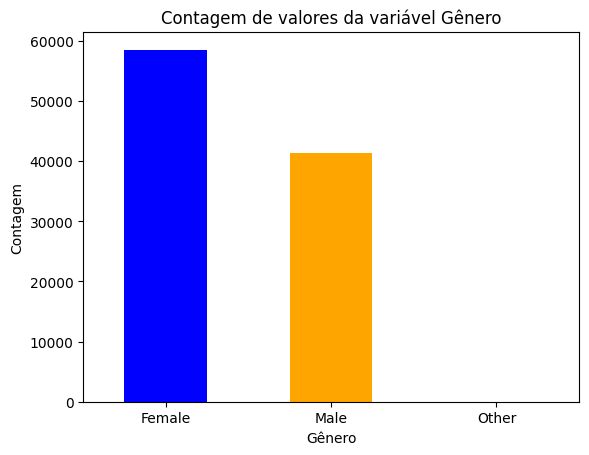

In [ ]:
plot_bar(x=df['gender'].value_counts(), var_name='Gênero', x_label='Gênero', y_label='Contagem', ticks=[0,1,2], labels=['Female', 'Male', 'Other'])

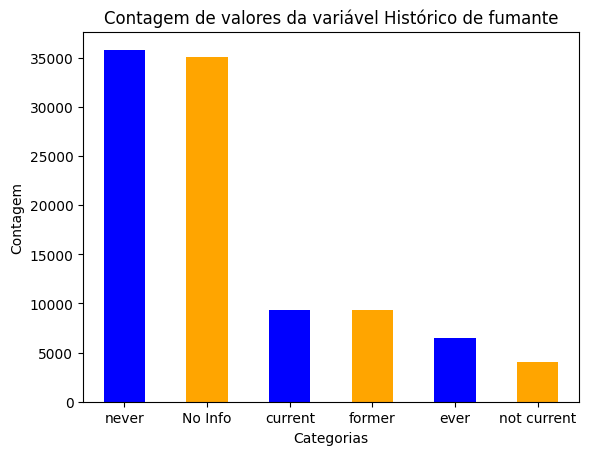

In [ ]:
  plot_bar(x=df['smoking_history'].value_counts(), var_name='Histórico de fumante', x_label='Categorias', y_label='Contagem', ticks=[0,1,2,3,4,5], labels=['never', 'No Info', 'current', 'former', 'ever', 'not current'])

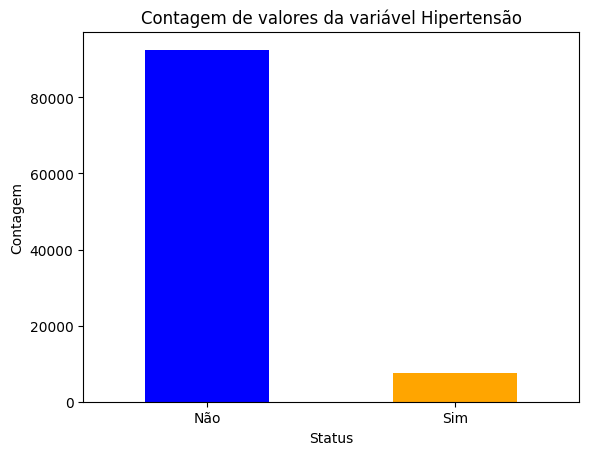

In [ ]:
plot_bar(x=df['hypertension'].value_counts(), var_name='Hipertensão', x_label='Status', y_label='Contagem', ticks=[0,1], labels=['Não', 'Sim'])

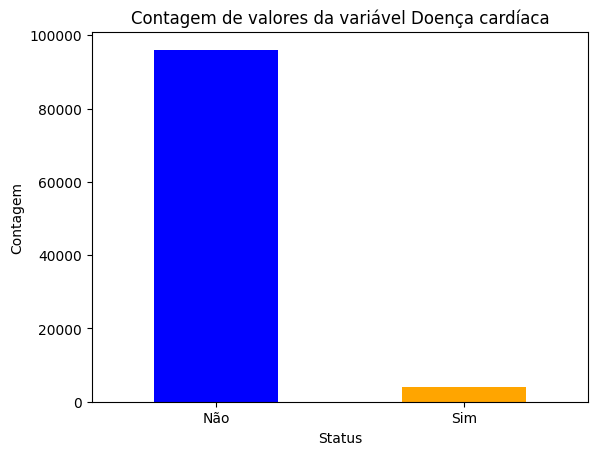

In [ ]:
plot_bar(x=df['heart_disease'].value_counts(), var_name='Doença cardíaca', x_label='Status', y_label='Contagem', ticks=[0,1], labels=['Não', 'Sim'])

#### Análise das variáveis contínuas

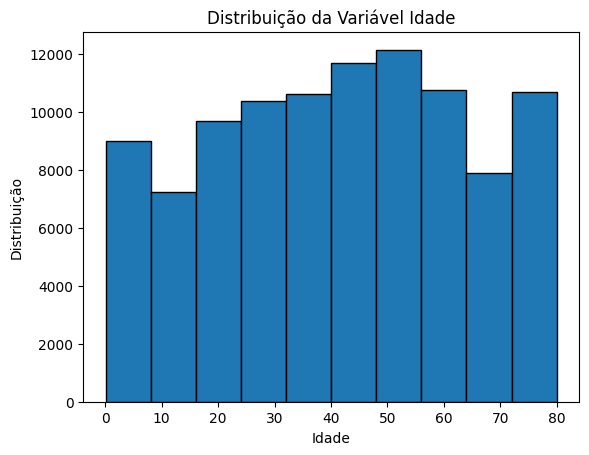

In [ ]:
plot_hist(df['age'], var_name='Idade', n_bins=10, x_label="Idade", y_label="Distribuição")

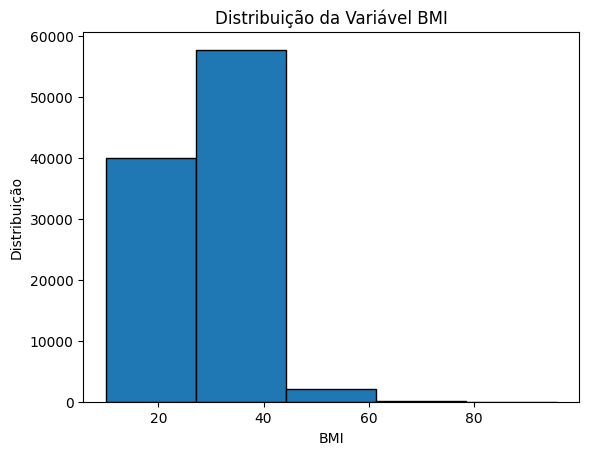

In [ ]:
plot_hist(df['bmi'], var_name='BMI', n_bins=5, x_label="BMI", y_label="Distribuição")

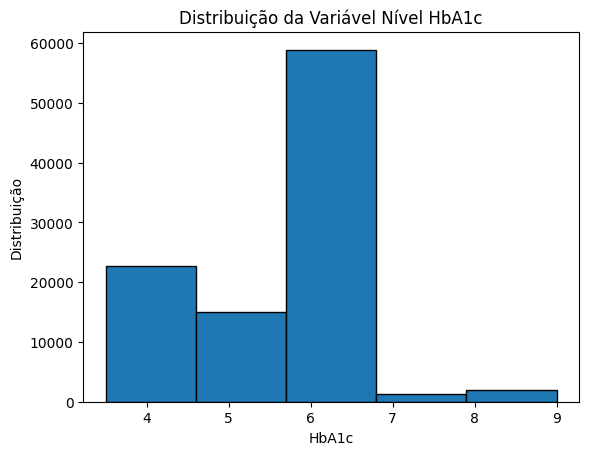

In [ ]:
plot_hist(df['HbA1c_level'], var_name='Nível HbA1c', n_bins=5, x_label="HbA1c", y_label="Distribuição")

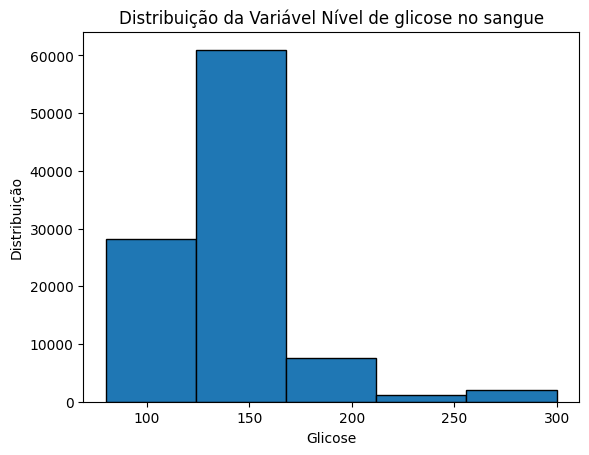

In [ ]:
plot_hist(df['blood_glucose_level'], var_name='Nível de glicose no sangue', n_bins=5, x_label="Glicose", y_label="Distribuição")

### Comparando variáveis numéricas com a variável alvo

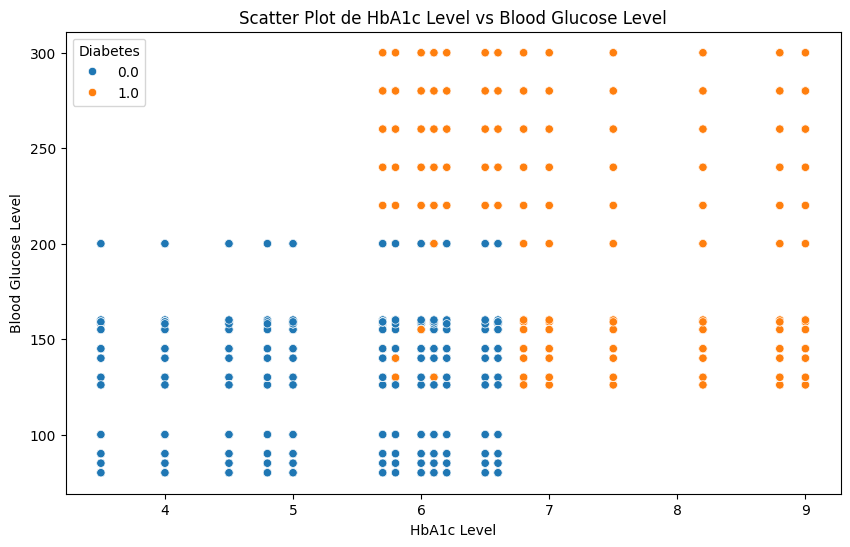

In [4]:
plt.figure(figsize=(10, 6))
scatter_scaled = sns.scatterplot(
    x='HbA1c_level',
    y='blood_glucose_level',
    hue='diabetes',
    data=df
)

plt.title('Scatter Plot de HbA1c Level vs Blood Glucose Level')
plt.xlabel('HbA1c Level')
plt.ylabel('Blood Glucose Level')
plt.legend(title='Diabetes', loc='upper left')

plt.show()

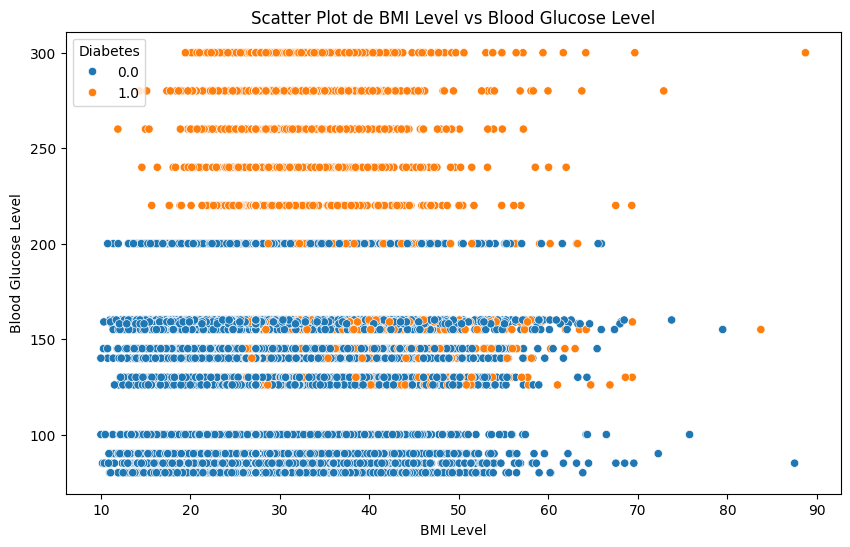

In [6]:
plt.figure(figsize=(10, 6))
scatter_scaled = sns.scatterplot(
    x='bmi',
    y='blood_glucose_level',
    hue='diabetes',
    data=df
)

plt.title('Scatter Plot de BMI Level vs Blood Glucose Level')
plt.xlabel('BMI Level')
plt.ylabel('Blood Glucose Level')
plt.legend(title='Diabetes', loc='upper left')

plt.show()

#### Análise de correlação entre variáveis

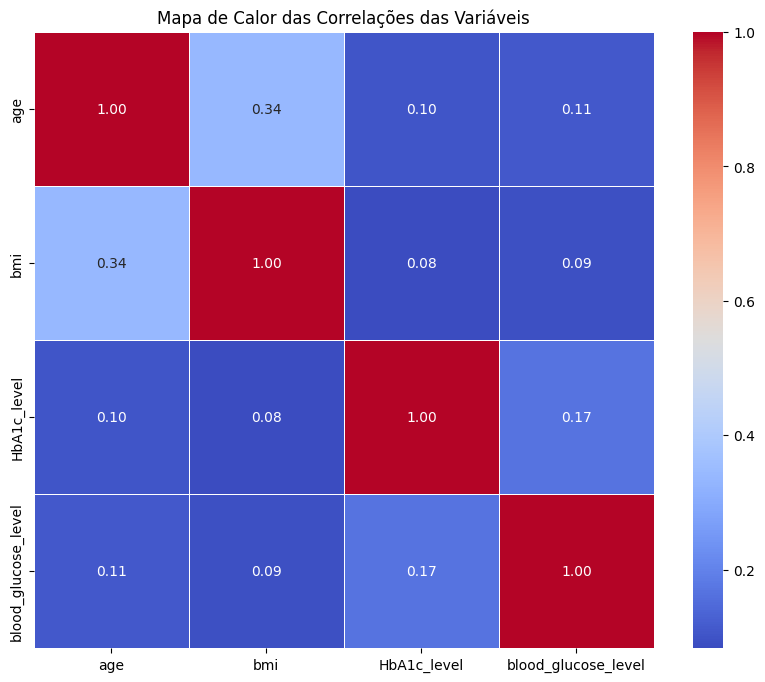

In [ ]:
correlation_matrix = df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']].corr()
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

plt.title('Mapa de Calor das Correlações das Variáveis')
plt.show()

## Pré-processamento dos dados, treinamento e resultados

Para as variáveis númericas, foi aplicado a transformação MinMax Scaler. A escolha desta transformação para os dados numéricos foi feita devido a diferença de escala entre as variáveis.

Para as variávieis categóricas, foi aplicado o processamento do tipo OneHotEncoding, visto que não queremos criar um "ranking" nas variáveis categóricas.

### Testando com todas as variáveis

In [ ]:
X = df[['gender', 'smoking_history', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']].copy()
y = df[['diabetes']].copy()

In [ ]:
X = pd.get_dummies(X, ['gender', 'smoking_history'])

scaler = MinMaxScaler()
X = pd.DataFrame(data=scaler.fit_transform(X))

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.0,1.0,0.177171,0.563636,0.272727,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.674675,0.0,0.0,0.202031,0.563636,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.349349,0.0,0.0,0.202031,0.400000,0.354545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.449449,0.0,0.0,0.156863,0.272727,0.340909,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.949950,1.0,1.0,0.118231,0.236364,0.340909,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,0.0,0.0,0.202031,0.490909,0.045455,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99996,0.024024,0.0,0.0,0.085901,0.545455,0.090909,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99997,0.824825,0.0,0.0,0.207983,0.400000,0.340909,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,0.299299,0.0,0.0,0.296569,0.090909,0.090909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
random_forest = RandomForestClassifier(n_estimators=40, random_state=42)
svm_poly = SVC(kernel = 'poly', random_state=42)
svm_rfb = SVC(kernel = 'rbf', random_state=42)
random_forest.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_rfb.fit(X_train, y_train)

y_pred_svm_poly = svm_poly.predict(X_test)
y_pred_svm_rfb = svm_rfb.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)

<ipython-input-27-65a059626dde>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
results = []
results = get_results('random_forest', classification_report(y_test, y_pred_random_forest, output_dict=True), results)
results = get_results('SVM_polynomial', classification_report(y_test, y_pred_svm_poly, output_dict=True), results)
results = get_results('SVM_RFB', classification_report(y_test, y_pred_svm_rfb, output_dict=True), results)

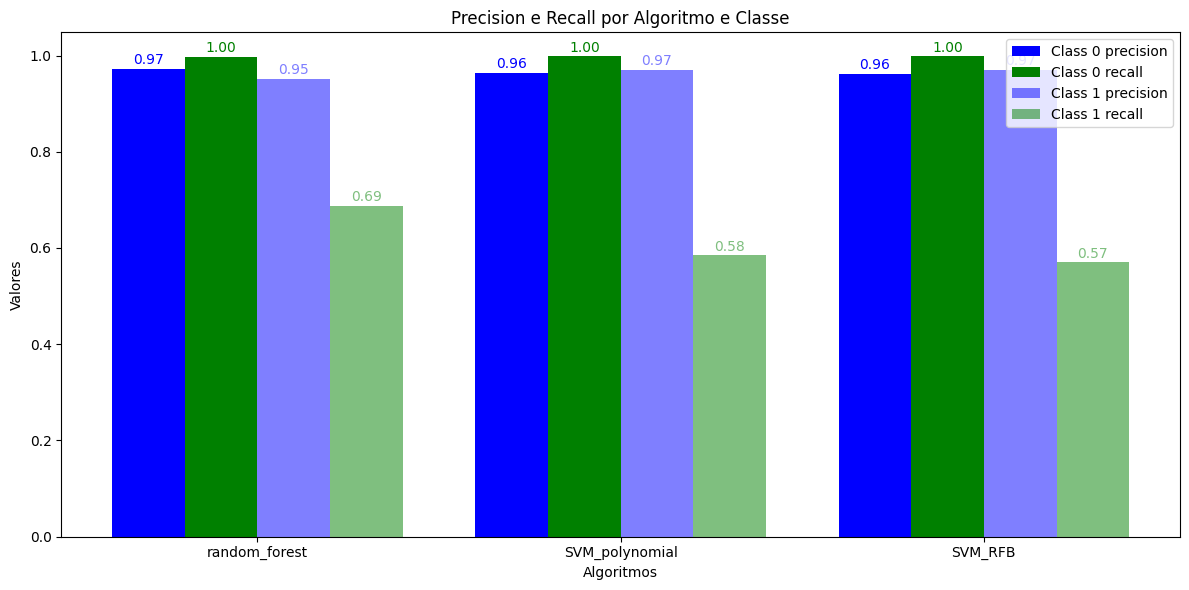

In [ ]:
plot_results(results)

Foi testado com todos os dados disponíveis, usando os algoritmos Random Forest e SVM com kernels diferentes, sendo o Kernel Polinomial e o Kernel RBF.

O que se mostrou mais viável de implementação seria o algoritmo Random Forest, devido ao recall mais alto do que os outros dois algoritmos na classe desejada para previsão. A precisão ficou parecida em todos os algoritmos.

### Utilizando apenas as variáveis relacionadas a dados clínicos

In [ ]:
X = df[['hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']].copy()
y = df[['diabetes']].copy()

In [ ]:
scaler = MinMaxScaler()
X = pd.DataFrame(data=scaler.fit_transform(X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
random_forest = RandomForestClassifier(n_estimators=40, random_state=42)
svm_poly = SVC(kernel = 'poly', random_state=42)
svm_rfb = SVC(kernel = 'rbf', random_state=42)
random_forest.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_rfb.fit(X_train, y_train)

y_pred_svm_poly = svm_poly.predict(X_test)
y_pred_svm_rfb = svm_rfb.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)

<ipython-input-33-65a059626dde>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
results = []
results = get_results('random_forest', classification_report(y_test, y_pred_random_forest, output_dict=True), results)
results = get_results('SVM_polynomial', classification_report(y_test, y_pred_svm_poly, output_dict=True), results)
results = get_results('SVM_RFB', classification_report(y_test, y_pred_svm_rfb, output_dict=True), results)

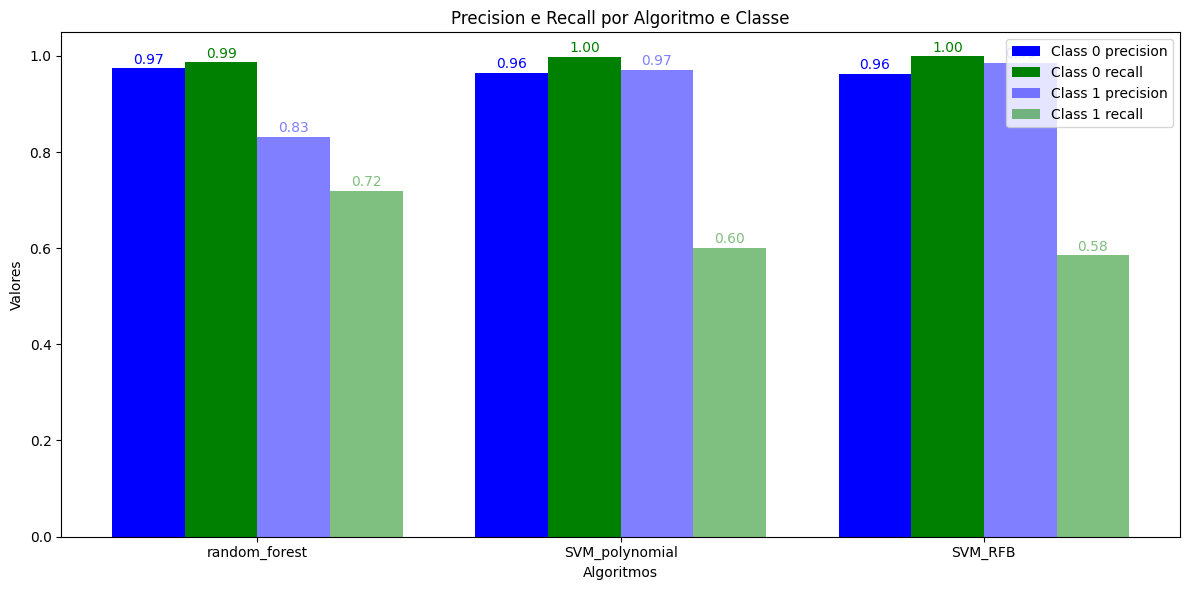

In [ ]:
plot_results(results)

Houveram algumas variações na precisão entre o teste anterior e o atual, porém o algoritmo Random Forest continua sendo superior no recall

### Utilizando apenas variáveis demográficas

In [ ]:
X = df[['gender', 'smoking_history', 'age']].copy()
y = df[['diabetes']].copy()

In [ ]:
X = pd.get_dummies(X, ['gender', 'smoking_history'])

scaler = MinMaxScaler()
X = pd.DataFrame(data=scaler.fit_transform(X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
random_forest = RandomForestClassifier(n_estimators=40, random_state=42)
svm_poly = SVC(kernel = 'poly', random_state=42)
svm_rfb = SVC(kernel = 'rbf', random_state=42)
random_forest.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_rfb.fit(X_train, y_train)

y_pred_svm_poly = svm_poly.predict(X_test)
y_pred_svm_rfb = svm_rfb.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)

<ipython-input-39-65a059626dde>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
results = []
results = get_results('random_forest', classification_report(y_test, y_pred_random_forest, output_dict=True), results)
results = get_results('SVM_polynomial', classification_report(y_test, y_pred_svm_poly, output_dict=True), results)
results = get_results('SVM_RFB', classification_report(y_test, y_pred_svm_rfb, output_dict=True), results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

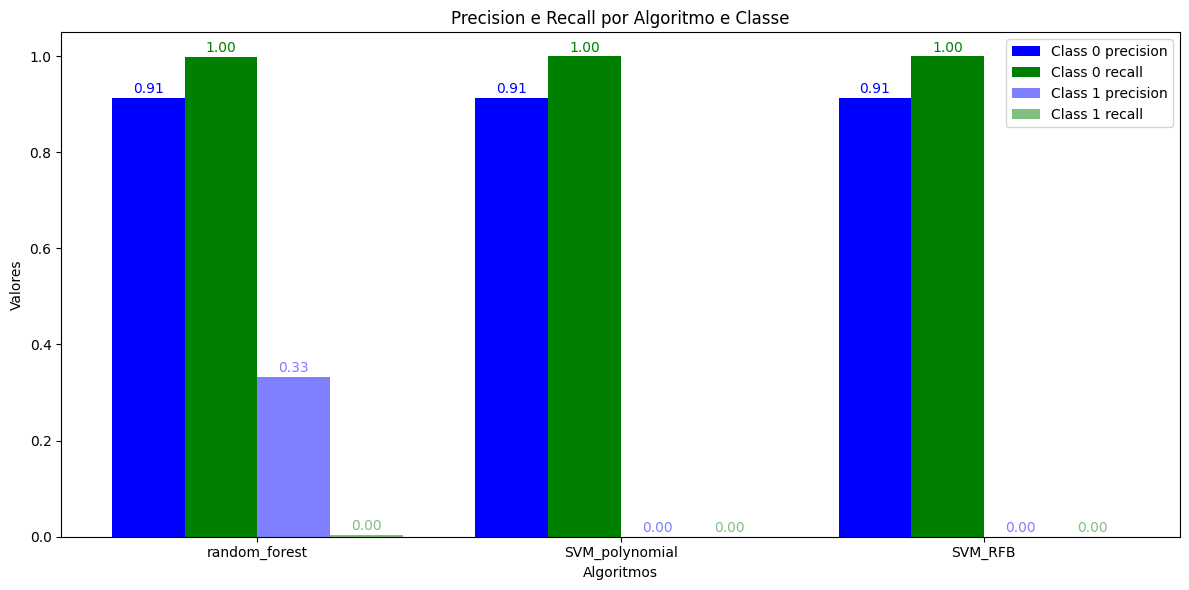

In [ ]:
plot_results(results)

Com os resultados deste terceiro teste, fica claro que não podemos explicar quem tem ou não tem diabetes apenas por dados demográficos. Para a classe positiva, todos os algoritmos tiveram resultados péssimos.

## Conclusão

Neste experimento, realizamos um treinamento de algoritmos de Machine Learning para tentar identificar pessoas com diabetes.

Em nosso dataset, estavam disponíveis dados clínicos e demográficos dos pacientes.

O algoritmo de Random Forest apresentou resultados mais estáveis comparados ao SVM, com uma precisão máxima de 95% e 70% de recall. O algoritmo SVM até conseguiu melhor precisão que o Random Forest apenas com as variáveis clinicas, porém com métricas de recall mais abaixo, ele é mais propenso a retornar falsos negativos, o que representa um grande problema para um algoritmo que tenta identificar uma doença em uma pessoa.

Por fim, como experimento, treinamos o algoritmo apenas com os dados demográficos para entender o impacto deles no algoritmo. Os resultados foram bem decepcionantes, e evidenciam que estes dados não tem uma influência tão grande para auxiliar na solução do problema.

Com base nas evidências acima, concluímos que o algoritmo Random Forest apresenta resultados mais estáveis do que o algoritmo SVM. O fator decisivo é a taxa de recall, onde o Random Forest é superior ao SVM.